Start with something simple, 2D, and only slightly nongaussian. The first will be a parabola-shaped gaussian-based pdf.

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

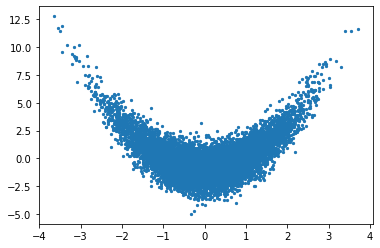

In [4]:
# Sample from the initial distribution
nsamples=10000
X_para = np.random.normal(0, 1, nsamples) 
Y_para = np.random.normal(X_para**2-1,1,nsamples)

plt.scatter(X_para,Y_para,s=5)

The example here is just going to be two 2d gaussians. Now to set up the MADE.


In [5]:
# Set up bijector MADE
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[12,12], activation='sigmoid') # not sure what hidden units are 

# Define the target distribution
base_distribution = tfd.Normal(loc=0., scale=1.)

target_distribution_para = tfd.TransformedDistribution(
    distribution=tfd.Sample(base_distribution, sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(made)) 

# Construct model.
x_ = tfk.Input(shape=(2,), dtype=tf.float32)
log_prob_ = target_distribution.log_prob(x_)
model_para = tfk.Model(x_, log_prob_)

model_para.compile(optimizer=tf.optimizers.Adam(),
              loss=lambda _, log_prob: -log_prob) 

# adam is a 'stochastic' gradient descent algorithm
# Don't quite understand the format of the loss function here. 

# now perform the fit
xdata_para = np.stack([X_para, Y_para], axis=-1)
ydata_para = base_distribution.sample(nsamples)

batch_size = 100
model_para.fit(x=xdata_para,
          y=np.zeros((int(nsamples), 2), dtype=np.float32),
          batch_size=batch_size,
          epochs=100,
          steps_per_epoch=50,  # Usually `n // batch_size`.
          validation_split=0.3,
          shuffle=True,
          verbose=True) #, ydata


2022-03-28 23:58:22.404054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 23:58:22.422311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 23:58:22.422437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 23:58:22.422717: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

NameError: name 'target_distribution' is not defined

Looks pretty Gausian! Now lets apply a fit, determine the full gaussian map, and plot some contours.

In [ ]:
from scipy.stats import multivariate_normal

# This is just a fixed gaussian. I first want to see how this lines up with the samples

dist_x, dist_y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((dist_x, dist_y))
rv = multivariate_normal([0., 0.], [[1.0, 0.], [0., 1.0]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contour(dist_x, dist_y, rv.pdf(pos),colors='w')
ax2.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])

In [ ]:
'''
Here what I am doing is finding values to perform the fit. I can start with using the previous histgram and using
a midpoint approximation.
'''

#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[0])
results = np.stack(ax2.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])[0])
#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[1])
#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[2])
binx=[]
biny=[]
edge_x = ax2.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])[1]
edge_y = ax2.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])[2]

for i in range(len(edge_x)-1):
    binx.append((edge_x[i+1]-edge_x[i])/2 + edge_x[i])
for i in range(len(edge_y)-1):
    biny.append((edge_y[i+1]-edge_y[i])/2 + edge_y[i])

bins=[]
z=[]
#bins.append(binx)
#bins.append(biny)
xvals = []
yvals = []

for i in range(len(binx)-1):
    for j in range(len(biny)-1):
        xvals.append(binx[i])
        yvals.append(biny[j])
        z.append(results[i][j])
        
#print(xvals)
#print(yvals)
#print(z)

In [ ]:
# Instead of relying on a perfect gaussian, instead I will perform a fit so that We can see where the loss 
# comes from. Ideally will have mean=(0,0) and cov=diag(1,1)

# Thanks https://stackoverflow.com/questions/52148141/2d-gaussian-fit-using-lmfit 
# since it has been so long since I used lmfit

from lmfit import Parameters, minimize, report_fit

def gaussian2D(x, y, cen_x, cen_y, sig_x, sig_y):
    return np.exp(-(((cen_x-x)/sig_x)**2 + ((cen_y-y)/sig_y)**2)/2.0)

def residuals(p, x, y, z):
    height = p["height"].value
    cen_x = p["centroid_x"].value
    cen_y = p["centroid_y"].value
    sigma_x = p["sigma_x"].value
    sigma_y = p["sigma_y"].value
    return (z - height*gaussian2D(x,y, cen_x, cen_y, sigma_x, sigma_y))

initial = Parameters()
initial.add("height",value=1.)
initial.add("centroid_x",value=0.)
initial.add("centroid_y",value=0.)
initial.add("sigma_x",value=1.)
initial.add("sigma_y",value=1.)

fit = minimize(residuals, initial, args=(xvals,yvals, z))
print(report_fit(fit))

# need to implement a covariance term in the model

In [ ]:
# Now plot the fit over the histogram
Xvals = np.linspace(-4,4,100)
Yvals = np.linspace(-4,4,100)
Xvals,Yvals = np.meshgrid(Xvals, Yvals)

xo = fit.params["centroid_x"].value
yo = fit.params["centroid_y"].value
sx = fit.params["sigma_x"].value
sy = fit.params["sigma_y"].value

Z=gaussian2D(Xvals,Yvals,xo,yo,sx,sy)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.contour(Xvals, Yvals, Z,colors='w')
ax3.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])

Now lets evaluate the NN fit. First I will take the sampled data and map it back to the non-gaussian parameter space. Then I will map the contours of the gaussian fit to the non-gaussian parameter space.

In [ ]:
'''
1. Sample from original distribution
2. pull back from the original to the gaussian using the NN bijector inverse
3. sample from gaussian
4. push forward from the gaussian to the original using NN bijector
'''

# resample from target distribution
X = np.random.normal(0, 1, 1000) 
Y = np.random.normal(X**2,1,1000)

test_data=np.stack((X,Y),axis=-1)

# resample from base distribution
s=1000
samples = base_distribution.sample((s,2))

x = samples[...,0].numpy()
y = samples[...,1].numpy()

# pull back target dist to normal base dist 
pullback = target_distribution.bijector.inverse(tf.cast(test_data,tf.float32))

pb_x = pullback[...,0].numpy()
pb_y = pullback[...,1].numpy()

# push forward normal dist. back to target
pushforward = target_distribution.bijector.forward(samples)

pf_x = pushforward[...,0].numpy()
pf_y = pushforward[...,1].numpy()

# plot
fig_original = plt.figure()
fig_transformed = plt.figure()
fig_sampled = plt.figure()
fig_inverse = plt.figure()
    
ax1 = fig_original.add_subplot(111)
ax2 = fig_transformed.add_subplot(111)
ax3 = fig_sampled.add_subplot(111)
ax4 = fig_inverse.add_subplot(111)

ax1.set_title("sampled from target")
ax2.set_title("pullback from target to base")
ax3.set_title("sampled from base")
ax4.set_title("pushforward from base to target")

ax1.scatter(X,Y,s=5)
ax2.scatter(pb_x,pb_y,s=5)
ax3.scatter(x,y,s=5)
ax4.scatter(pf_x,pf_y,s=5)

Cool!

In [ ]:
# Evaluate fit on gaussian, pushforward to find contours

x_points , y_points = np.mgrid[-3:3:.05, -3:3:.05]
xy_points = np.stack((x_points, y_points),axis=-1)
print(x_points)
print(y_points)
z_vals=gaussian2D(x_points,y_points,xo,yo,sx,sy)
x_pos=[]
y_pos=[]

#for i in range(len(x_points)):
#    for j in range(len(y_points)):
#        pos=xy_points[i][j]
#        z_vals.append(gaussian2D(pos[0],pos[1],xo,yo,sx,sy))
#        append to list to use when evaluating NN model
#        x_pos.append(pos[0])
#        y_pos.append(pos[1])

# pushforward points to target distribution
contour_pushforward = target_distribution.bijector.forward(tf.cast(xy_points,tf.float32))

contour_x = contour_pushforward[...,0].numpy()
contour_y = contour_pushforward[...,1].numpy()
    
#np.stack((contour_x,contour_y),axis=-1)
#print(contour_x)
#print(contour_y)

In [ ]:
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.contour(contour_x,contour_y,z_vals,colors='w')

In the plot above, what I did was take the gaussian contours and map them under the bijector from the neural net. We can see that this matches well with the initial generated distribution. Lastly, lets try to estimate the mass above 0. My strategy is as follows:

1. Using the contours found above, determine the contour that passes through the origin.
2. Sample points from the normalized space and map them to the 

NameError: name 'pf_x' is not defined

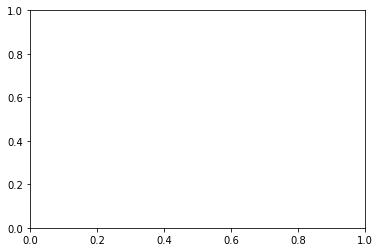

In [6]:
## Add a visualization for the origin

fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.contour(contour_x,contour_y,z_vals,colors='w')
ax.plot([0,0],[-4,10],color='k',linestyle='dashed')
ax.plot([-5,5],[0,0],color='k',linestyle='dashed')
ax.scatter(0,0,color='k')

In [ ]:
# Visualize what happens to the origin in the original parameter space under the pullback

origin_pullback = target_distribution.bijector.inverse([0.,0.])
print(origin_pullback)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot([0,0],[-4,4],color='k',linestyle='dashed')
ax3.plot([-4,4],[0,0],color='k',linestyle='dashed')
ax3.plot([-4,4],[1,1],color='k',linestyle='dashed')
ax3.contour(Xvals, Yvals, Z,colors='w')
ax3.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])
ox_pb = origin_pullback.numpy()[0]
oy_pb = origin_pullback.numpy()[1]
ax3.scatter(ox_pb,oy_pb,color='k')

In [7]:
# Compare pdf values. Use the prob from original distribution to compute MC integral

po_pb=gaussian2D(ox_pb,oy_pb,xo,yo,sx,sy)
print(po_pb)

prob = target_distribution.prob([0.,0.])
print(prob)

NameError: name 'gaussian2D' is not defined

In [8]:
# Plot contour

z_vals = target_distribution.prob(xy_points)
print(len(xy_points))
print(len(z_vals))
x_vals = xy_points
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
#ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.plot([0,0],[-3,3],color='k',linestyle='dashed')
ax.plot([-3,3],[0,0],color='k',linestyle='dashed')
ax.contour(x_points , y_points,z_vals,colors='b',levels=[prob])
ax.scatter(0,0,color='k')

NameError: name 'target_distribution' is not defined

To compute the integral, I can sample from the gaussian and use monte carlo integration. I can test whether a point lies in the 0-contour region of the domain. I don't know how to do error analysis for monte carlo integration, so I cannot implement anything in that regard right now.

In [9]:
# integrate

n_points = 10000
n_pass = 0

_s = target_distribution.sample(n_points)
_v = target_distribution.prob(_s)
for val in _v:
    if val>prob:
        n_pass+=1
        
print(n_pass/n_points)

NameError: name 'target_distribution' is not defined

Now lets try another simple example: two 2d gaussians separated in space. This time the distribution is multimodal, so the contour passing through the origin may be more complicated. I have tried this a few times, and the main problem it has is that it just tries to shift the two gaussians, so the inverse map does nothing more than stretch along some axis. You can see the loss function is much higher at the end of the training than for the above case. Bijectors must be smooth functions, so there is a restriction about how the shift can occur.

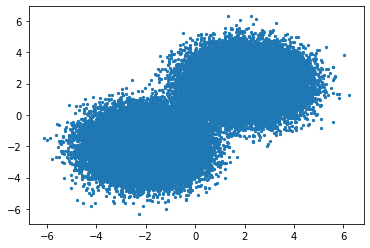

In [78]:
# Create the initial distribution
nsamples=100000
X1 = np.random.normal(-2, 1, int(nsamples/2))
X2 = np.random.normal(2, 1, int(nsamples/2)) 
Y1 = np.random.normal(-2,1,int(nsamples/2))
Y2 = np.random.normal(2,1,int(nsamples/2))

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

plt.scatter(X,Y,s=5)

In [79]:
## NN setup

# Set up bijector MADE
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[12,12,12,12], activation='sigmoid') # not sure what hidden units are 

# Define the target distribution
base_distribution = tfd.Normal(loc=0., scale=1.)

target_distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(base_distribution, sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(made)) 

# Construct model.
x_ = tfk.Input(shape=(2,), dtype=tf.float32)
log_prob_ = target_distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss=lambda _, log_prob: -log_prob) 

# adam is a 'stochastic' gradient descent algorithm
# Don't quite understand the format of the loss function here. 

# now perform the fit
xdata = np.stack([X, Y], axis=-1)
ydata = base_distribution.sample(nsamples)
#print(data)
#plt.scatter(X,Y,s=5)

batch_size = 1000
model.fit(x=xdata,
          y=np.zeros((int(nsamples), 2), dtype=np.float32),
          batch_size=batch_size,
          epochs=100,
          steps_per_epoch=50,  # Usually `n // batch_size`.
          validation_split=0.3,
          shuffle=True,
          verbose=True) #, ydata


Epoch 1/100
50/50 [==============================] - 0s 3ms/step - loss: 4.7790 - val_loss: 5.5812
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 3.9636 - val_loss: 4.7985
Epoch 3/100
50/50 [==============================] - 0s 2ms/step - loss: 3.7103 - val_loss: 4.2257
Epoch 4/100
50/50 [==============================] - 0s 2ms/step - loss: 3.6430 - val_loss: 4.2185
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: 3.6326 - val_loss: 4.2190
Epoch 6/100
50/50 [==============================] - 0s 2ms/step - loss: 3.6306 - val_loss: 4.2460
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: 3.6320 - val_loss: 4.2499
Epoch 8/100
50/50 [==============================] - 0s 2ms/step - loss: 3.6363 - val_loss: 4.2648
Epoch 9/100
50/50 [==============================] - 0s 1ms/step - loss: 3.6252 - val_loss: 4.2870
Epoch 10/100
50/50 [==============================] - 0s 2ms/step - loss: 3.6366 - val_loss: 4.2516
Epoch 11/

50/50 [==============================] - 0s 2ms/step - loss: 3.6314 - val_loss: 4.2815
Epoch 84/100
50/50 [==============================] - 0s 2ms/step - loss: 3.6348 - val_loss: 4.2816
Epoch 85/100
50/50 [==============================] - 0s 2ms/step - loss: 3.6336 - val_loss: 4.2362
Epoch 86/100
50/50 [==============================] - 0s 2ms/step - loss: 3.6298 - val_loss: 4.2418
Epoch 87/100
50/50 [==============================] - 0s 2ms/step - loss: 3.6284 - val_loss: 4.2465
Epoch 88/100
50/50 [==============================] - 0s 2ms/step - loss: 3.6302 - val_loss: 4.2705
Epoch 89/100
50/50 [==============================] - 0s 2ms/step - loss: 3.6336 - val_loss: 4.2546
Epoch 90/100
50/50 [==============================] - 0s 2ms/step - loss: 3.6287 - val_loss: 4.2790
Epoch 91/100
50/50 [==============================] - 0s 2ms/step - loss: 3.6292 - val_loss: 4.2689
Epoch 92/100
50/50 [==============================] - 0s 2ms/step - loss: 3.6293 - val_loss: 4.2417
Epoch 93/100


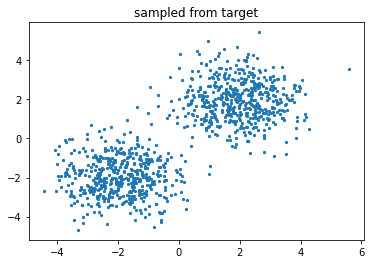

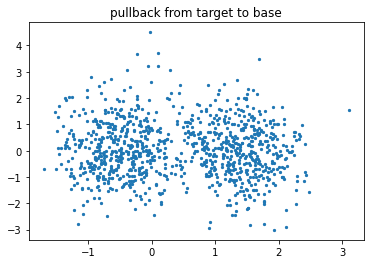

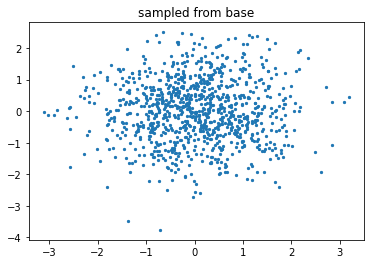

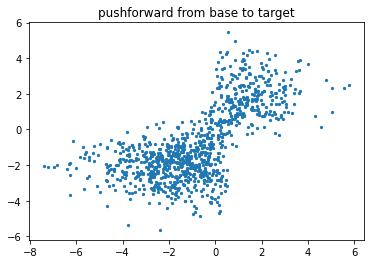

In [82]:
### Check bijector
# resample from target distribution
nsamples=1000
X1 = np.random.normal(-2, 1, int(nsamples/2))
X2 = np.random.normal(2, 1, int(nsamples/2)) 
Y1 = np.random.normal(-2,1,int(nsamples/2))
Y2 = np.random.normal(2,1,int(nsamples/2))

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

test_data=np.stack((X,Y),axis=-1)

# resample from base distribution
s=1000
samples = base_distribution.sample((s,2))

x = samples[...,0].numpy()
y = samples[...,1].numpy()

# pull back target dist to normal base dist 
pullback = target_distribution.bijector.inverse(tf.cast(test_data,tf.float32))

pb_x = pullback[...,0].numpy()
pb_y = pullback[...,1].numpy()

# push forward normal dist. back to target
pushforward = target_distribution.bijector.forward(samples)

pf_x = pushforward[...,0].numpy()
pf_y = pushforward[...,1].numpy()

# plot
fig_original = plt.figure()
fig_transformed = plt.figure()
fig_sampled = plt.figure()
fig_inverse = plt.figure()
    
ax1 = fig_original.add_subplot(111)
ax2 = fig_transformed.add_subplot(111)
ax3 = fig_sampled.add_subplot(111)
ax4 = fig_inverse.add_subplot(111)

ax1.set_title("sampled from target")
ax2.set_title("pullback from target to base")
ax3.set_title("sampled from base")
ax4.set_title("pushforward from base to target")

ax1.scatter(X,Y,s=5)
ax2.scatter(pb_x,pb_y,s=5)
ax3.scatter(x,y,s=5)
ax4.scatter(pf_x,pf_y,s=5)

tf.Tensor(0.03156527, shape=(), dtype=float32)
2000
2000
integral =  0.4776


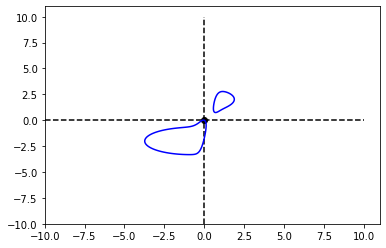

In [83]:
prob = target_distribution.prob([0.,0.])
print(prob)

x_points , y_points = np.mgrid[-10:10:.01, -10:10:.01]
xy_points = np.stack((x_points, y_points),axis=-1)

z_vals = target_distribution.prob(xy_points)
print(len(xy_points))
print(len(z_vals))
x_vals = xy_points
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
#ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.plot([0,0],[-10,10],color='k',linestyle='dashed')
ax.plot([-10,10],[0,0],color='k',linestyle='dashed')
ax.contour(x_points , y_points,z_vals,colors='b',levels=[prob])
ax.scatter(0,0,color='k')

n_points = 10000
n_pass = 0

_s = target_distribution.sample(n_points)
_v = target_distribution.prob(_s)
for val in _v:
    if val>prob:
        n_pass+=1
        
print("integral = ",n_pass/n_points)

One more example. Lets instead combine the two previous examples!

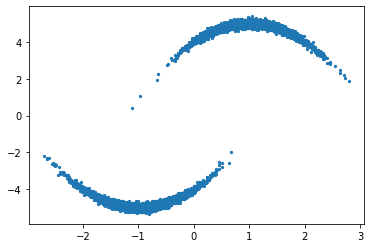

In [84]:
# Create the initial distribution

nsamples=10000
center = 1
stdevx = 0.5
stdevy = 0.1
shifty = 5

X1 = np.random.normal(-1*center, stdevx, int(nsamples/2))
X2 = np.random.normal(center, stdevx, int(nsamples/2)) 
Y1 = np.random.normal((X1+center)**2-shifty, stdevy, int(nsamples/2))
Y2 = np.random.normal(-(X2-center)**2+shifty,stdevy,int(nsamples/2))

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

plt.scatter(X,Y,s=5)

In [85]:
## NN setup

# Set up bijector MADE
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[12,12], activation='sigmoid') # not sure what hidden units are 

# Define the target distribution
base_distribution = tfd.Normal(loc=0., scale=1.)

target_distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(base_distribution, sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(made)) 

# Construct model.
x_ = tfk.Input(shape=(2,), dtype=tf.float32)
log_prob_ = target_distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss=lambda _, log_prob: -log_prob) 

# adam is a 'stochastic' gradient descent algorithm
# Don't quite understand the format of the loss function here. 

# now perform the fit
xdata = np.stack([X, Y], axis=-1)
ydata = base_distribution.sample(nsamples)
#print(data)
#plt.scatter(X,Y,s=5)

batch_size = 100
model.fit(x=xdata,
          y=np.zeros((int(nsamples), 2), dtype=np.float32),
          batch_size=batch_size,
          epochs=100,
          steps_per_epoch=50,  # Usually `n // batch_size`.
          validation_split=0.3,
          shuffle=True,
          verbose=True) #, ydata


Epoch 1/100
50/50 [==============================] - 0s 3ms/step - loss: 9.9741 - val_loss: 5.7831
Epoch 2/100
50/50 [==============================] - 0s 1ms/step - loss: 4.4548 - val_loss: 5.5509
Epoch 3/100
50/50 [==============================] - 0s 1ms/step - loss: 4.3463 - val_loss: 5.4841
Epoch 4/100
50/50 [==============================] - 0s 1ms/step - loss: 4.3260 - val_loss: 5.4477
Epoch 5/100
50/50 [==============================] - 0s 1ms/step - loss: 4.3050 - val_loss: 5.3865
Epoch 6/100
50/50 [==============================] - 0s 1ms/step - loss: 4.2906 - val_loss: 5.4869
Epoch 7/100
50/50 [==============================] - 0s 1ms/step - loss: 4.2598 - val_loss: 5.4977
Epoch 8/100
50/50 [==============================] - 0s 1ms/step - loss: 4.2287 - val_loss: 5.6113
Epoch 9/100
50/50 [==============================] - 0s 1ms/step - loss: 4.2438 - val_loss: 5.5271
Epoch 10/100
50/50 [==============================] - 0s 1ms/step - loss: 4.1749 - val_loss: 5.7000
Epoch 11/

50/50 [==============================] - 0s 1ms/step - loss: 1.8402 - val_loss: 4.3094
Epoch 84/100
50/50 [==============================] - 0s 1ms/step - loss: 1.8519 - val_loss: 4.1327
Epoch 85/100
50/50 [==============================] - 0s 1ms/step - loss: 1.7787 - val_loss: 4.0315
Epoch 86/100
50/50 [==============================] - 0s 2ms/step - loss: 1.6725 - val_loss: 4.4402
Epoch 87/100
50/50 [==============================] - 0s 1ms/step - loss: 1.7393 - val_loss: 4.7569
Epoch 88/100
50/50 [==============================] - 0s 1ms/step - loss: 1.7839 - val_loss: 4.5861
Epoch 89/100
50/50 [==============================] - 0s 1ms/step - loss: 1.7091 - val_loss: 3.6582
Epoch 90/100
50/50 [==============================] - 0s 1ms/step - loss: 1.7250 - val_loss: 3.8512
Epoch 91/100
50/50 [==============================] - 0s 1ms/step - loss: 1.5978 - val_loss: 4.6923
Epoch 92/100
50/50 [==============================] - 0s 1ms/step - loss: 1.6865 - val_loss: 3.5499
Epoch 93/100


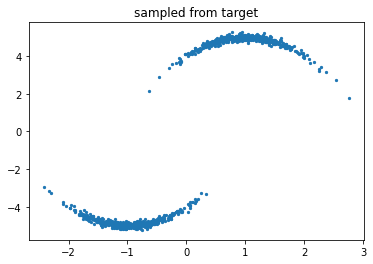

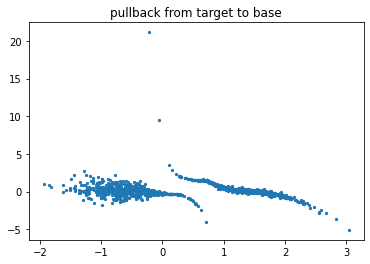

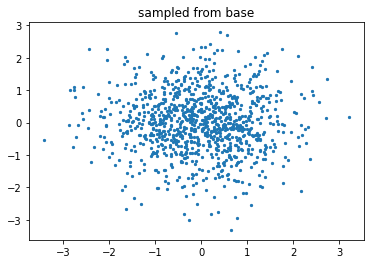

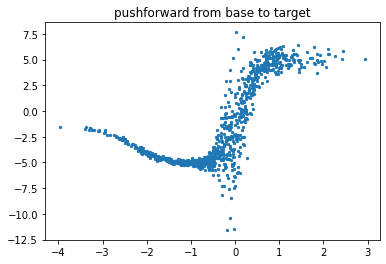

In [86]:
### Check bijector
# resample from target distribution
nsamples=1000

X1 = np.random.normal(-1*center, stdevx, int(nsamples/2))
X2 = np.random.normal(center, stdevx, int(nsamples/2)) 
Y1 = np.random.normal((X1+center)**2-shifty, stdevy, int(nsamples/2))
Y2 = np.random.normal(-(X2-center)**2+shifty,stdevy,int(nsamples/2))

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

test_data=np.stack((X,Y),axis=-1)

# resample from base distribution
s=1000
samples = base_distribution.sample((s,2))

x = samples[...,0].numpy()
y = samples[...,1].numpy()

# pull back target dist to normal base dist 
pullback = target_distribution.bijector.inverse(tf.cast(test_data,tf.float32))

pb_x = pullback[...,0].numpy()
pb_y = pullback[...,1].numpy()

# push forward normal dist. back to target
pushforward = target_distribution.bijector.forward(samples)

pf_x = pushforward[...,0].numpy()
pf_y = pushforward[...,1].numpy()

# plot
fig_original = plt.figure()
fig_transformed = plt.figure()
fig_sampled = plt.figure()
fig_inverse = plt.figure()
    
ax1 = fig_original.add_subplot(111)
ax2 = fig_transformed.add_subplot(111)
ax3 = fig_sampled.add_subplot(111)
ax4 = fig_inverse.add_subplot(111)

ax1.set_title("sampled from target")
ax2.set_title("pullback from target to base")
ax3.set_title("sampled from base")
ax4.set_title("pushforward from base to target")

ax1.scatter(X,Y,s=5)
ax2.scatter(pb_x,pb_y,s=5)
ax3.scatter(x,y,s=5)
ax4.scatter(pf_x,pf_y,s=5)

tf.Tensor(0.037212197, shape=(), dtype=float32)
2000
2000
integral =  0.8068


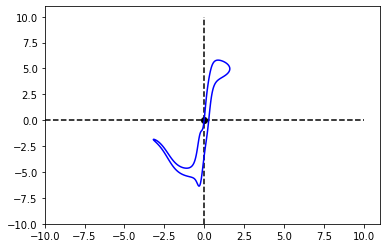

In [87]:
prob = target_distribution.prob([0.,0.])
print(prob)

x_points , y_points = np.mgrid[-10:10:.01, -10:10:.01]
xy_points = np.stack((x_points, y_points),axis=-1)

z_vals = target_distribution.prob(xy_points)
print(len(xy_points))
print(len(z_vals))
x_vals = xy_points
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
#ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.plot([0,0],[-10,10],color='k',linestyle='dashed')
ax.plot([-10,10],[0,0],color='k',linestyle='dashed')
ax.contour(x_points , y_points,z_vals,colors='b',levels=[prob])
ax.scatter(0,0,color='k')

n_points = 10000
n_pass = 0

_s = target_distribution.sample(n_points)
_v = target_distribution.prob(_s)
for val in _v:
    if val>prob:
        n_pass+=1
        
print("integral = ",n_pass/n_points)